In [2]:
pip install opencv-python numpy scikit-image matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/13/de/291cbb17f44242ed6bfd3450fc2535d6bd298115c0ccd6f01cd51d4a11d7/opencv_python-4.13.0.90-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/8c/de/f5e79650d23d9e12f38a7bc6b03ea0835b9575494f8ec94c11c6e773b1b1/numpy-2.4.1-cp311-cp311-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for scipy>=1.8 from https://files.pythonhosted.org/packages/52/c8/08629657ac6c0da198487ce8cd3de78e02cfde42b7f34117d56a3fe249dc/scipy-1.17.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2.4.1 which is incompatible.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim 
from skimage.util import random_noise

In [11]:
def add_noise(image, mode='gaussian'):
    """
    Adds synthetic noise to an image.
    Modes: 'gaussian', 's&p' (salt and pepper)
    """
    if mode == 'gaussian':
        # Add Gaussian noise
        noisy = random_noise(image, mode='gaussian', var=0.01)
    elif mode == 's&p':
        # Add Salt & Pepper noise
        noisy = random_noise(image, mode='s&p', amount=0.05)
    else:
        return image
    
    # Random_noise returns float [0,1], convert back to uint8 [0,255]
    return np.array(255 * noisy, dtype=np.uint8)

In [6]:
def calculate_metrics(original, filtered):
    """
    Calculates PSNR and SSIM between the original (clean) and filtered images.
    """
    # Calculate PSNR
    psnr_val = cv2.PSNR(original, filtered)
    
    # Calculate SSIM
    # win_size must be odd and smaller than image dimensions; 7 is standard
    ssim_val, _ = ssim(original, filtered, full=True, win_size=7)
    
    return psnr_val, ssim_val

In [7]:
image_path = './dataset/BSDS300/images/train/2092.jpg' 
original_img = cv2.imread(image_path)

In [12]:
if original_img is None:
    print("Error: Image not found. Please ensure the path is correct.")
else:
    # 2. Convert to Grayscale
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    # 3. Add Synthetic Noise
    # We will create two noisy versions as per methodology
    gaussian_noisy_img = add_noise(gray_img, mode='gaussian')
    sp_noisy_img = add_noise(gray_img, mode='s&p')

    # 4. Apply Filters
    
    # --- Experiment A: Cleaning Gaussian Noise ---
    # Gaussian Filter (Kernel size 5x5, sigmaX 1)
    gauss_filtered_g = cv2.GaussianBlur(gaussian_noisy_img, (5, 5), 1)
    
    # Median Filter (Kernel size 5) - usually better for Salt & Pepper, but we test on Gaussian too
    median_filtered_g = cv2.medianBlur(gaussian_noisy_img, 5)
    
    # Bilateral Filter (d=9, sigmaColor=75, sigmaSpace=75)
    bilateral_filtered_g = cv2.bilateralFilter(gaussian_noisy_img, 9, 75, 75)

    # --- Experiment B: Cleaning Salt & Pepper Noise ---
    # Gaussian Filter
    gauss_filtered_sp = cv2.GaussianBlur(sp_noisy_img, (5, 5), 1)
    
    # Median Filter
    median_filtered_sp = cv2.medianBlur(sp_noisy_img, 5)
    
    # Bilateral Filter
    bilateral_filtered_sp = cv2.bilateralFilter(sp_noisy_img, 9, 75, 75)

    # 5. Evaluate (PSNR & SSIM)
    results = {
        "Gaussian Noise - Gaussian Filter": calculate_metrics(gray_img, gauss_filtered_g),
        "Gaussian Noise - Median Filter": calculate_metrics(gray_img, median_filtered_g),
        "Gaussian Noise - Bilateral Filter": calculate_metrics(gray_img, bilateral_filtered_g),
        "S&P Noise - Gaussian Filter": calculate_metrics(gray_img, gauss_filtered_sp),
        "S&P Noise - Median Filter": calculate_metrics(gray_img, median_filtered_sp),
        "S&P Noise - Bilateral Filter": calculate_metrics(gray_img, bilateral_filtered_sp),
    }

In [14]:
# Print Quantitative Results
print(f"{'Experiment':<40} | {'PSNR (dB)':<10} | {'SSIM':<10}")
print("-" * 66)
for key, (psnr, ssim_v) in results.items():
    print(f"{key:<40} | {psnr:<10.2f} | {ssim_v:<10.4f}")

Experiment                               | PSNR (dB)  | SSIM      
------------------------------------------------------------------
Gaussian Noise - Gaussian Filter         | 27.52      | 0.6006    
Gaussian Noise - Median Filter           | 26.53      | 0.5752    
Gaussian Noise - Bilateral Filter        | 28.15      | 0.6927    
S&P Noise - Gaussian Filter              | 26.54      | 0.5628    
S&P Noise - Median Filter                | 28.04      | 0.7720    
S&P Noise - Bilateral Filter             | 24.56      | 0.5572    


In [15]:
# 6. Visual Comparison (Plotting)
titles = ['Original', 'Gaussian Noisy', 'S&P Noisy', 
            'Gauss Filt (on G)', 'Median Filt (on G)', 'Bilateral (on G)',
            'Gauss Filt (on S&P)', 'Median Filt (on S&P)', 'Bilateral (on S&P)']
    
images = [gray_img, gaussian_noisy_img, sp_noisy_img,
            gauss_filtered_g, median_filtered_g, bilateral_filtered_g,
            gauss_filtered_sp, median_filtered_sp, bilateral_filtered_sp]

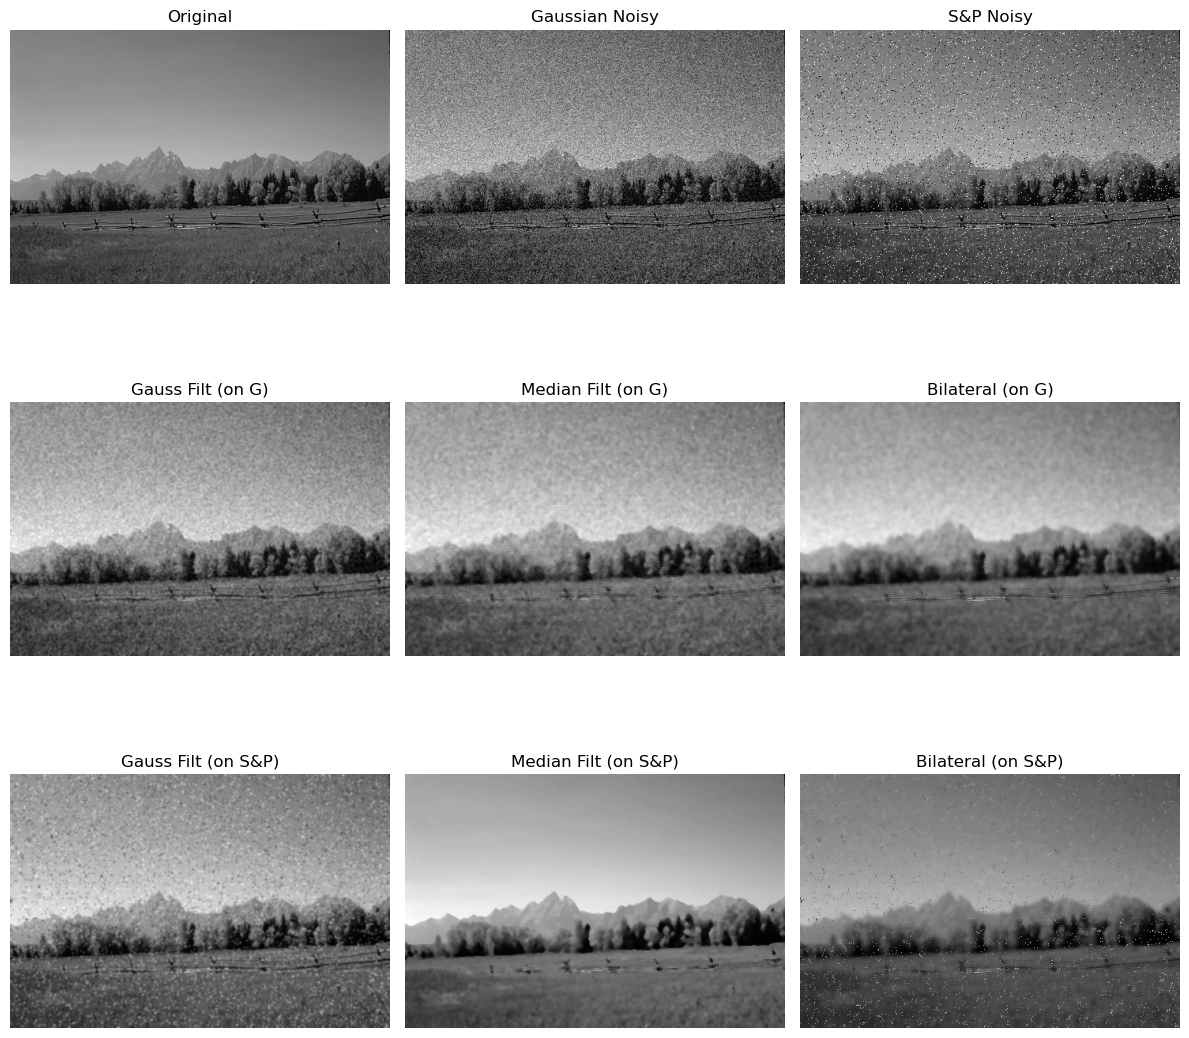

In [16]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()